# In this notebook we're going to be looking at a physics informed neural netwrok

## My background is in plasma physics, and the fundamental system of equations which described how an idea plasma evolves are Maxwells equations and the lorentz equation of motion. For a static electromagnetic field, the lorentz equation of motion can be solved to give the trajectory of a charged particle over time.

In [1]:
import numpy as np
from scipy.integrate import odeint
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

## Lets start by solving this equation for a charged particle with some initial velocity and position in a constant crossed EM field.

In [2]:
def lorentz(X, t, e_field, b_field, charge2mass):
    """
    Gives the acceleration of a changed particle in an electromagnetic field.
    :param X: particle coordinates [x, y, z, vx, vy, vz]
    :param t: time
    :param e_field: Electric field
    :param b_Field: Magnetic field
    :param charge2mass: particle charge to mass ratio
    :return: particle vecolity and accelertion [x, y, z, vx, vy, vz]
    """
    dx = X[3:]
    d2x = charge2mass * (e_field + np.cross(X[3:], b_field))
    return np.append(dx, d2x)
    

## Perhaps counterintuitively, the particle has no period averaged velocity in the direction of the electric field. Instead it has a drift velocity perpindicular to both the electric and magnetic fields.

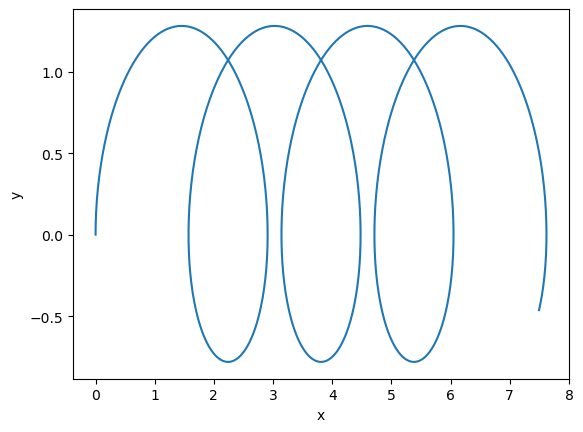

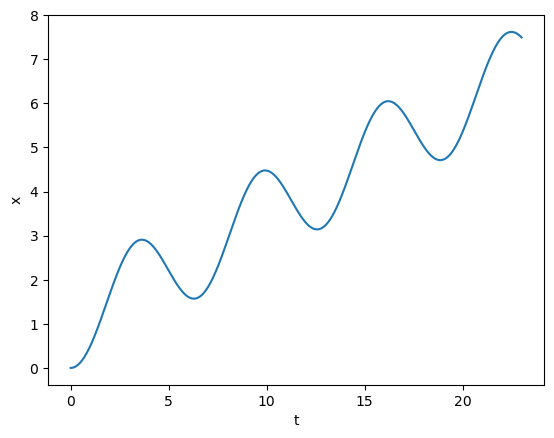

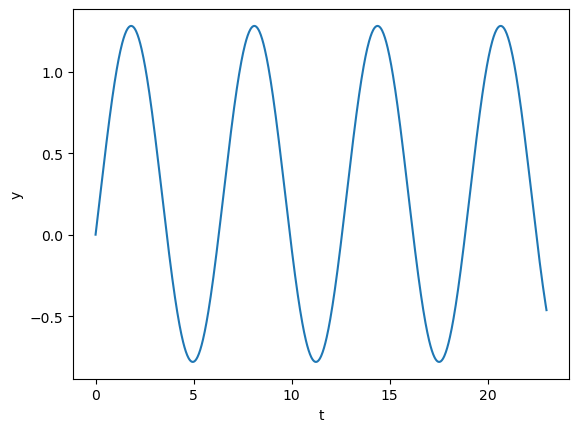

In [3]:
X0 = np.array([0, 0, 0, 0, 1, 0])
t = np.linspace(0, 23, 1000)
e_field = np.array([0, 0.25, 0])
b_field = np.array([0, 0, 1])
charge2mass = 1.0

sol = odeint(lorentz, X0, t, args=(e_field, b_field, charge2mass))
x = sol[:,0]
y = sol[:,1]
z = sol[:,2]
vx = sol[:,3]
vy = sol[:,4]
vz = sol[:,5]

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("y")
fig, ax = plt.subplots()
ax.plot(t, x)
ax.set_xlabel("t")
ax.set_ylabel("x")
fig, ax = plt.subplots()
ax.plot(t, y)
ax.set_xlabel("t")
ax.set_ylabel("y")
plt.show()

## A situation in which we might encounter these trajectories is a tokamak. Due to the extreme conditions in tokamaks, material can be boken off the walls and fall into the core of the machine. These lumps of mateiral rapidly become charged and then start to move under the electric and magnetic fields of the machine. These solid lumps of material are refered to as dust.

## If we ran an experiment to try and mearure the dust trajectory, we would setup a camera in the device to measure the particles location. Our data would then consist of noisy snap-shots of the particles position, which might not cover the who region of interest (i.e. if the particle moves beyond the view of the camera)

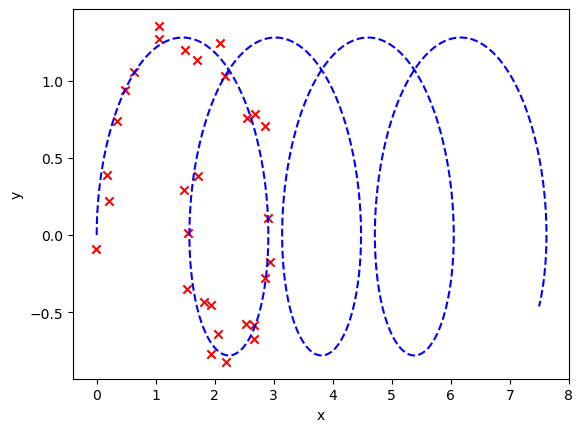

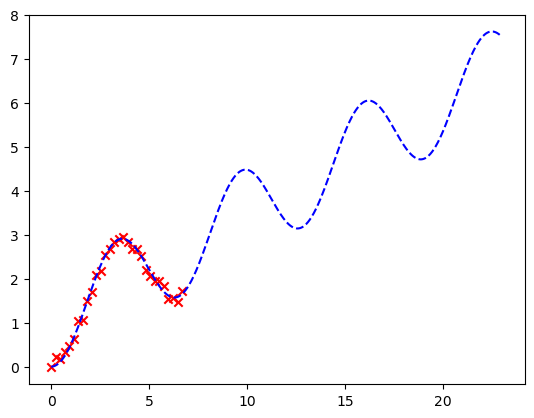

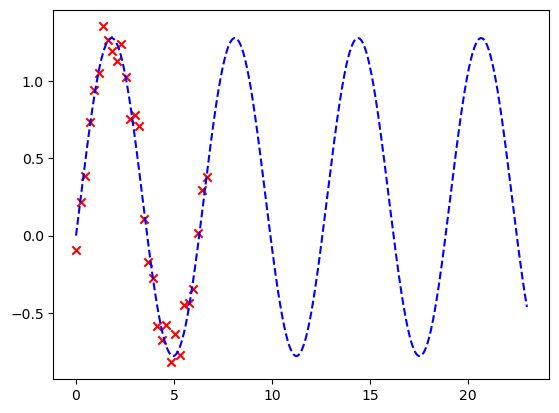

In [4]:
# Get some noisy samples along path
samples_x = x[:300:10] + np.random.normal(0, 0.1, len(x[:300:10]))
samples_y = y[:300:10] + np.random.normal(0, 0.1, len(y[:300:10]))
samples_t = t[:300:10]
fig, ax = plt.subplots()
ax.plot(x, y, ls='--', color='blue')
ax.scatter(samples_x, samples_y, marker='x', color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')

fig, ax = plt.subplots()
ax.scatter(samples_t, samples_x, marker='x', color='red')
ax.plot(t, x, ls='--', color='blue')
fig, ax = plt.subplots()
ax.plot(t, y, ls='--', color='blue')
ax.scatter(samples_t, samples_y, marker='x', color='red')
plt.show()


## With this data set, we can try and model the underlying latent trajectory using machine learning. So lets apply a vanilia NN 

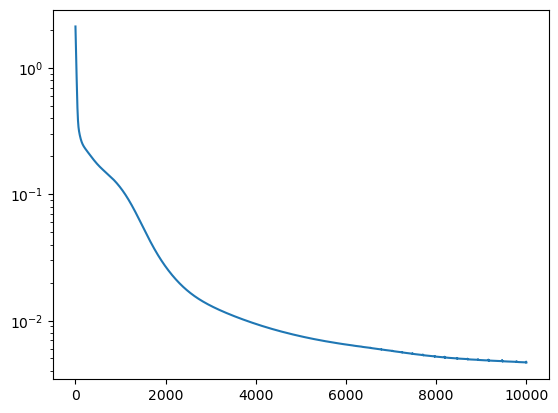

In [5]:
class TrackNet(torch.nn.Module):
    
    def __init__(self):
        super(TrackNet, self).__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 2))
        
    def forward(self, t):
        return self.net(t)
    
# Define netowrk optimiser / loss function
network = TrackNet()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

# convert traing data to pytorch tensors
t_data = torch.tensor(samples_t, dtype=torch.float)[:, None]
X_data = torch.tensor(np.array([samples_x, samples_y]).T, dtype=torch.float)

# Train 
epochs = 10000
losses = []
for i in range(epochs):
    optimizer.zero_grad()
    
    # Calculate loss
    output = network(t_data)
    loss = loss_fn(X_data, output)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
        
plt.semilogy(losses)
plt.show()


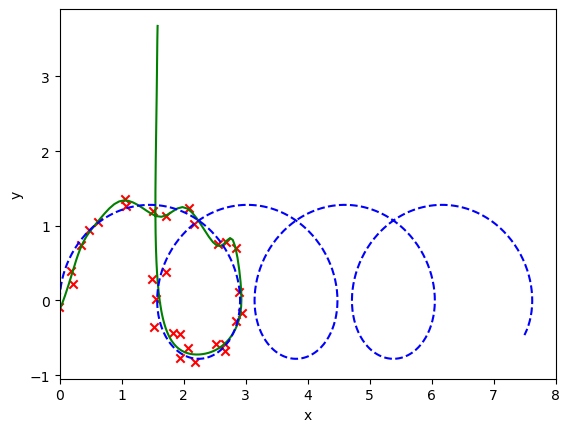

In [6]:
t_axis = torch.linspace(0, samples_t[-1] * 10, 1000)[:, None]

with torch.no_grad():
    X_pred = network(t_axis)

fig, ax = plt.subplots()
ax.plot(X_pred.numpy()[:, 0], X_pred.numpy()[:, 1], color='green')
ax.scatter(samples_x, samples_y, marker='x', color='red')
ax.plot(x, y, ls='--', color='blue')
ax.set_xlim([0, 8])
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

## This is doing an ok job at predicting the trajectory inside the data set (although we are overfitting to the noise a little). However, it is very poor at extrapolating beyond the data set.

## To help our model generalise better to points beyond our data sets, we can use a physics informed neural networ or PINN. Here we add a second term to our loss function in which we solve the lorentz eom over the region of interest. This forces our regression function to be a solution to the appropriate physics equations. We can use torch auto-grad to make solving the ODE much easier.

In [7]:
# now try PINN
class TrackNet(torch.nn.Module):
    
    def __init__(self):
        super(TrackNet, self).__init__()
        self.net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 2))
        
    def forward(self, t):
        return self.net(t)
    
    def grad_1st(self, t):
        # Calculates the first gradient
        X = self(t)
        d_x = grad(X[:, 0], t, torch.ones_like(X[:, 0]), create_graph=True)[0]
        d_y = grad(X[:, 1], t, torch.ones_like(X[:, 1]), create_graph=True)[0]
        return torch.hstack((d_x, d_y))

    def grad_2nd(self, t):
        # Calculates the second gradient.
        dX_dt = self.grad_1st(t)
        d2_x = grad(dX_dt[:, 0], t, torch.ones_like(dX_dt[:, 0]), create_graph=True)[0]
        d2_y = grad(dX_dt[:, 1], t, torch.ones_like(dX_dt[:, 1]), create_graph=True)[0]
        return torch.hstack((d2_x, d2_y))

    
def physics_loss(grad_1st, grad_2nd, charge2mass, e_field, b_field):
    # Solves the lorentz equation of motion
    a_x = charge2mass * (e_field[0] + grad_1st[:, 1] * b_field)[:,None]
    a_y = charge2mass * (e_field[1] - grad_1st[:, 0] * b_field)[:,None]
    a = torch.hstack((a_x, a_y))
    return torch.mean((grad_2nd - a)**2.0)


def data_loss(target, output):
    # same loss as previously.
    return torch.mean((target - output)**2.0)


# Define netowrk optimiser / loss function
network = TrackNet()
optimizer = torch.optim.Adam(network.parameters(), lr=5e-4)

# convert traing data to pytorch tensors
time_data = torch.tensor(samples_t, dtype=torch.float)[:, None]
X_data = torch.tensor(np.array([samples_x, samples_y]).T, dtype=torch.float)
time_physics = torch.linspace(-5, 25, 200)[:,None]
time_physics.requires_grad = True



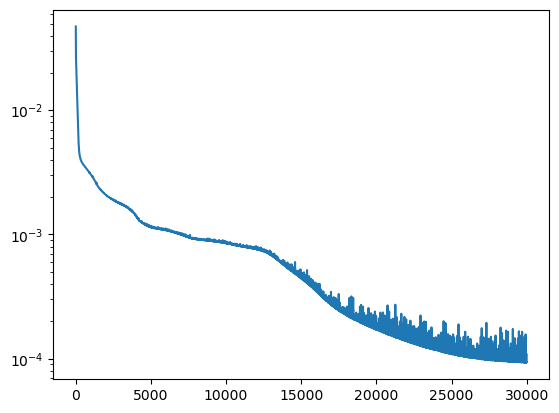

In [8]:
# Train 
epochs = 30000
losses = []
eps = 0.01
for i in range(epochs):
    optimizer.zero_grad()
    
    # Calculate data loss
    output_data = network(time_data)
    output_physics = network(time_physics)
    grad_1 = network.grad_1st(time_physics)
    grad_2 = network.grad_2nd(time_physics)
    
    loss = physics_loss(grad_1, grad_2, 1, [0, 0.25], 1) + eps * data_loss(output_data, X_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
        
plt.semilogy(losses)
plt.show()

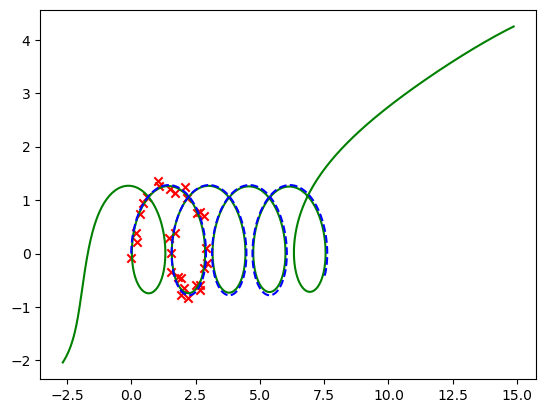

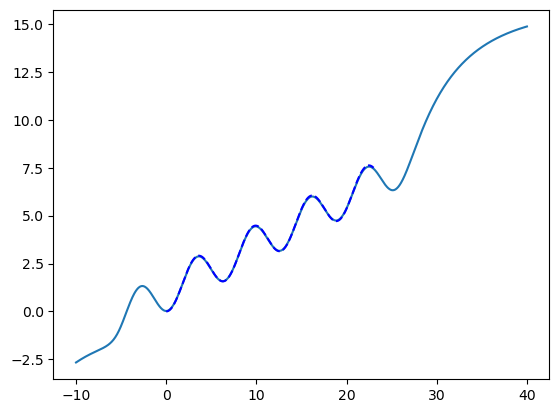

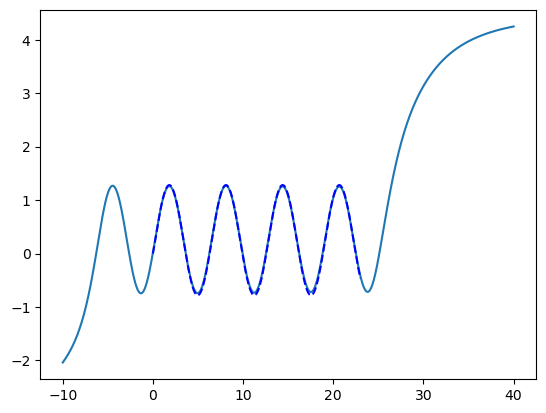

In [9]:
t_axis = torch.linspace(-10, 40, 1000)[:, None]
with torch.no_grad():
    X_pred = network(t_axis)
fig, ax = plt.subplots()
ax.plot(X_pred.numpy()[:, 0], X_pred.numpy()[:, 1], color='green')
ax.scatter(samples_x, samples_y, marker='x', color='red')
ax.plot(x, y, ls='--', color='blue')
fig, ax = plt.subplots()
ax.plot(t_axis, X_pred.numpy()[:, 0])
ax.plot(t, x, ls='--', color='blue')
fig, ax = plt.subplots()
ax.plot(t_axis, X_pred.numpy()[:, 1])
ax.plot(t, y, ls='--', color='blue')

plt.show()

## The model now does a much better job at predicting the trajectory outside the region of our data set!